In [583]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso

from sklearn.cross_validation import train_test_split
from sklearn import metrics


from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

In [621]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [622]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


In [623]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [624]:
train = train.loc[train.likes < 210000]

In [625]:
y_train = train['adview']
train.drop(['adview'], axis=1, inplace=True)
x_train = train

In [626]:
x_train.shape

(14634, 8)

In [627]:
x_test = test.drop(['vidid'], axis=1)
x_train = train.drop(['vidid'], axis=1)

In [628]:
x_train.shape

(14634, 7)

In [629]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

x_train = x_train.apply(time_transform, axis=1)
x_test = x_test.apply(time_transform, axis=1)

In [630]:
x_train.head()

,views,likes,dislikes,comment,published,duration,category
0,1031602.0,8523.0,363.0,1095.0,2016-09-14,457,F
1,1707.0,56.0,2.0,6.0,2016-10-01,570,D
2,2023.0,25.0,0.0,2.0,2016-07-02,136,C
3,620860.0,777.0,161.0,153.0,2016-07-27,262,H
4,666.0,1.0,0.0,0.0,2016-06-29,31,D


In [631]:
x_test.head()

,views,likes,dislikes,comment,published,duration,category
0,440238.0,6153.0,218.0,1377.0,2017-02-18,449,B
1,1040132.0,8171.0,340.0,1047.0,2016-06-28,389,F
2,28534.0,31.0,11.0,1.0,2014-03-10,2274,D
3,1316715.0,2284.0,250.0,274.0,2010-06-05,595,G
4,1893173.0,2519.0,225.0,116.0,2016-09-03,188,B


#### Label Encoding

In [632]:
lbl = preprocessing.LabelEncoder()

In [633]:
lbl.fit(list(x_train['category'].values))
x_train['category'] = lbl.transform(list(x_train['category'].values))
x_test['category'] = lbl.transform(list(x_test['category'].values))

In [634]:
x_train['published'] = pd.to_datetime(x_train['published'])
x_test['published'] = pd.to_datetime(x_test['published'])

In [635]:
x_train['dayofweek'] = x_train.published.dt.dayofweek
x_test['dayofweek'] = x_test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

In [636]:
x_train['year'] = x_train.published.dt.year
x_test['year'] = x_test.published.dt.year

x_train['month'] = x_train.published.dt.month
x_test['month'] = x_test.published.dt.month

In [637]:
x_train.drop(['published'], axis=1, inplace=True)
x_test.drop(['published'], axis=1, inplace=True)

In [512]:
temp = x_train.copy()

In [479]:
temp = temp.loc[temp.likes < 22]

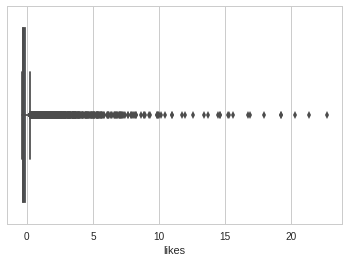

In [495]:
sns.boxplot(temp.likes)

In [481]:
temp.shape

(14634, 9)

In [483]:
x_train = temp

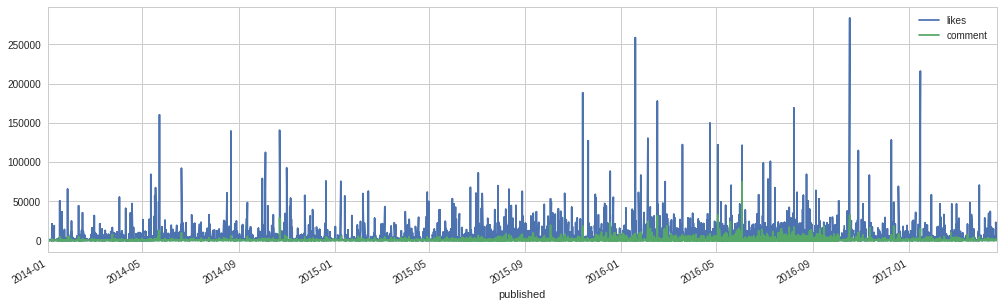

In [55]:
temp[['likes','comment','published']].plot(x= 'published', figsize=(17,5))

In [57]:
temp['dayofweek'] = temp.published.dt.dayofweek

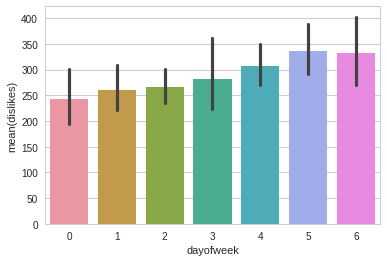

In [68]:
sns.barplot(x='dayofweek', y='dislikes', data=temp)

In [71]:
columns = ['views', 'likes', 'dislikes', 'comment', 'dayofweek', 'duration']

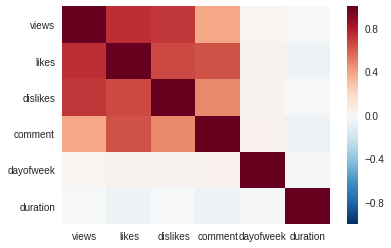

In [72]:
sns.heatmap(temp[columns].corr())

# Random Forest

In [638]:
columns = ['views', 'likes', 'dislikes', 'comment', 'duration']

In [639]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(x_train[columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [640]:
x_train[columns] = std_scaler.transform(x_train[columns])

In [544]:
columns = ['views', 'likes', 'dislikes', 'comment', 'duration', 'category',
       'dayofweek', 'year', 'month']

In [545]:
x_train.head()

,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,0.142176,0.707556,0.110809,0.465447,-0.251770,5,2,2016,9
1,-0.291273,-0.327420,-0.247895,-0.269562,-0.202999,3,5,2016,10
2,-0.291140,-0.331209,-0.249883,-0.272262,-0.390314,2,5,2016,7
3,-0.030692,-0.239288,-0.089907,-0.170346,-0.335932,7,2,2016,7
4,-0.291711,-0.334143,-0.249883,-0.273612,-0.435632,3,2,2016,6


In [460]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True,n_estimators=300)

In [461]:
param_grid = { "max_features"      : [0.25, 0.3, 0.35],
           "min_impurity_split" : [3, 6, 8] 
           }

In [304]:
grid_search = GridSearchCV(random_forest, param_grid, n_jobs=-1, cv=6)

In [305]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=6, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.2, 1], 'max_depth': [40, 60, 80], 'min_impurity_split': [3, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [306]:
print (grid_search.best_params_)

{'max_depth': 60, 'max_features': 0.2, 'min_impurity_split': 3}


In [546]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True, max_depth= 60, max_features=0.3, min_impurity_split=6, n_estimators=300)

In [562]:
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=6,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [563]:
y_pred = random_forest.predict(x_test)

In [564]:
random_forest.score(x_train, y_train)

0.85652642152831771

In [575]:
print (random_forest.class_weight)

None


In [565]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(x_train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(random_forest.feature_importances_)

# preview
coeff_df

,Features,Coefficient Estimate
0,views,0.231441
1,likes,0.148366
2,dislikes,0.165461
3,comment,0.125195
4,duration,0.098797
5,category,0.044125
6,dayofweek,0.036686
7,year,0.096172
8,month,0.053756


In [620]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("R2 score: %f" % metrics.r2_score(y_test, y_pred))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 300,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
    ridge_clf = Ridge(alpha=0.001, normalize=True)
    print ("Ridge Regression")
    model_train(ridge_clf, X, y)
    
    #Lasso Regression
    lasso_clf = Lasso(alpha=0.001, normalize=True)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #MLP Regression
    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
    print ("MLP (NN)")
    model_train(mlp_clf, X, y)
    
    
    return rand_clf, mlp_clf, ridge_clf, lasso_clf

rand_reg,ridge_reg, lasso_reg, mlp_reg = training(x_train, y_train)


Random Forests


ValueError: Found input variables with inconsistent numbers of samples: [13613, 14634]

# Rough

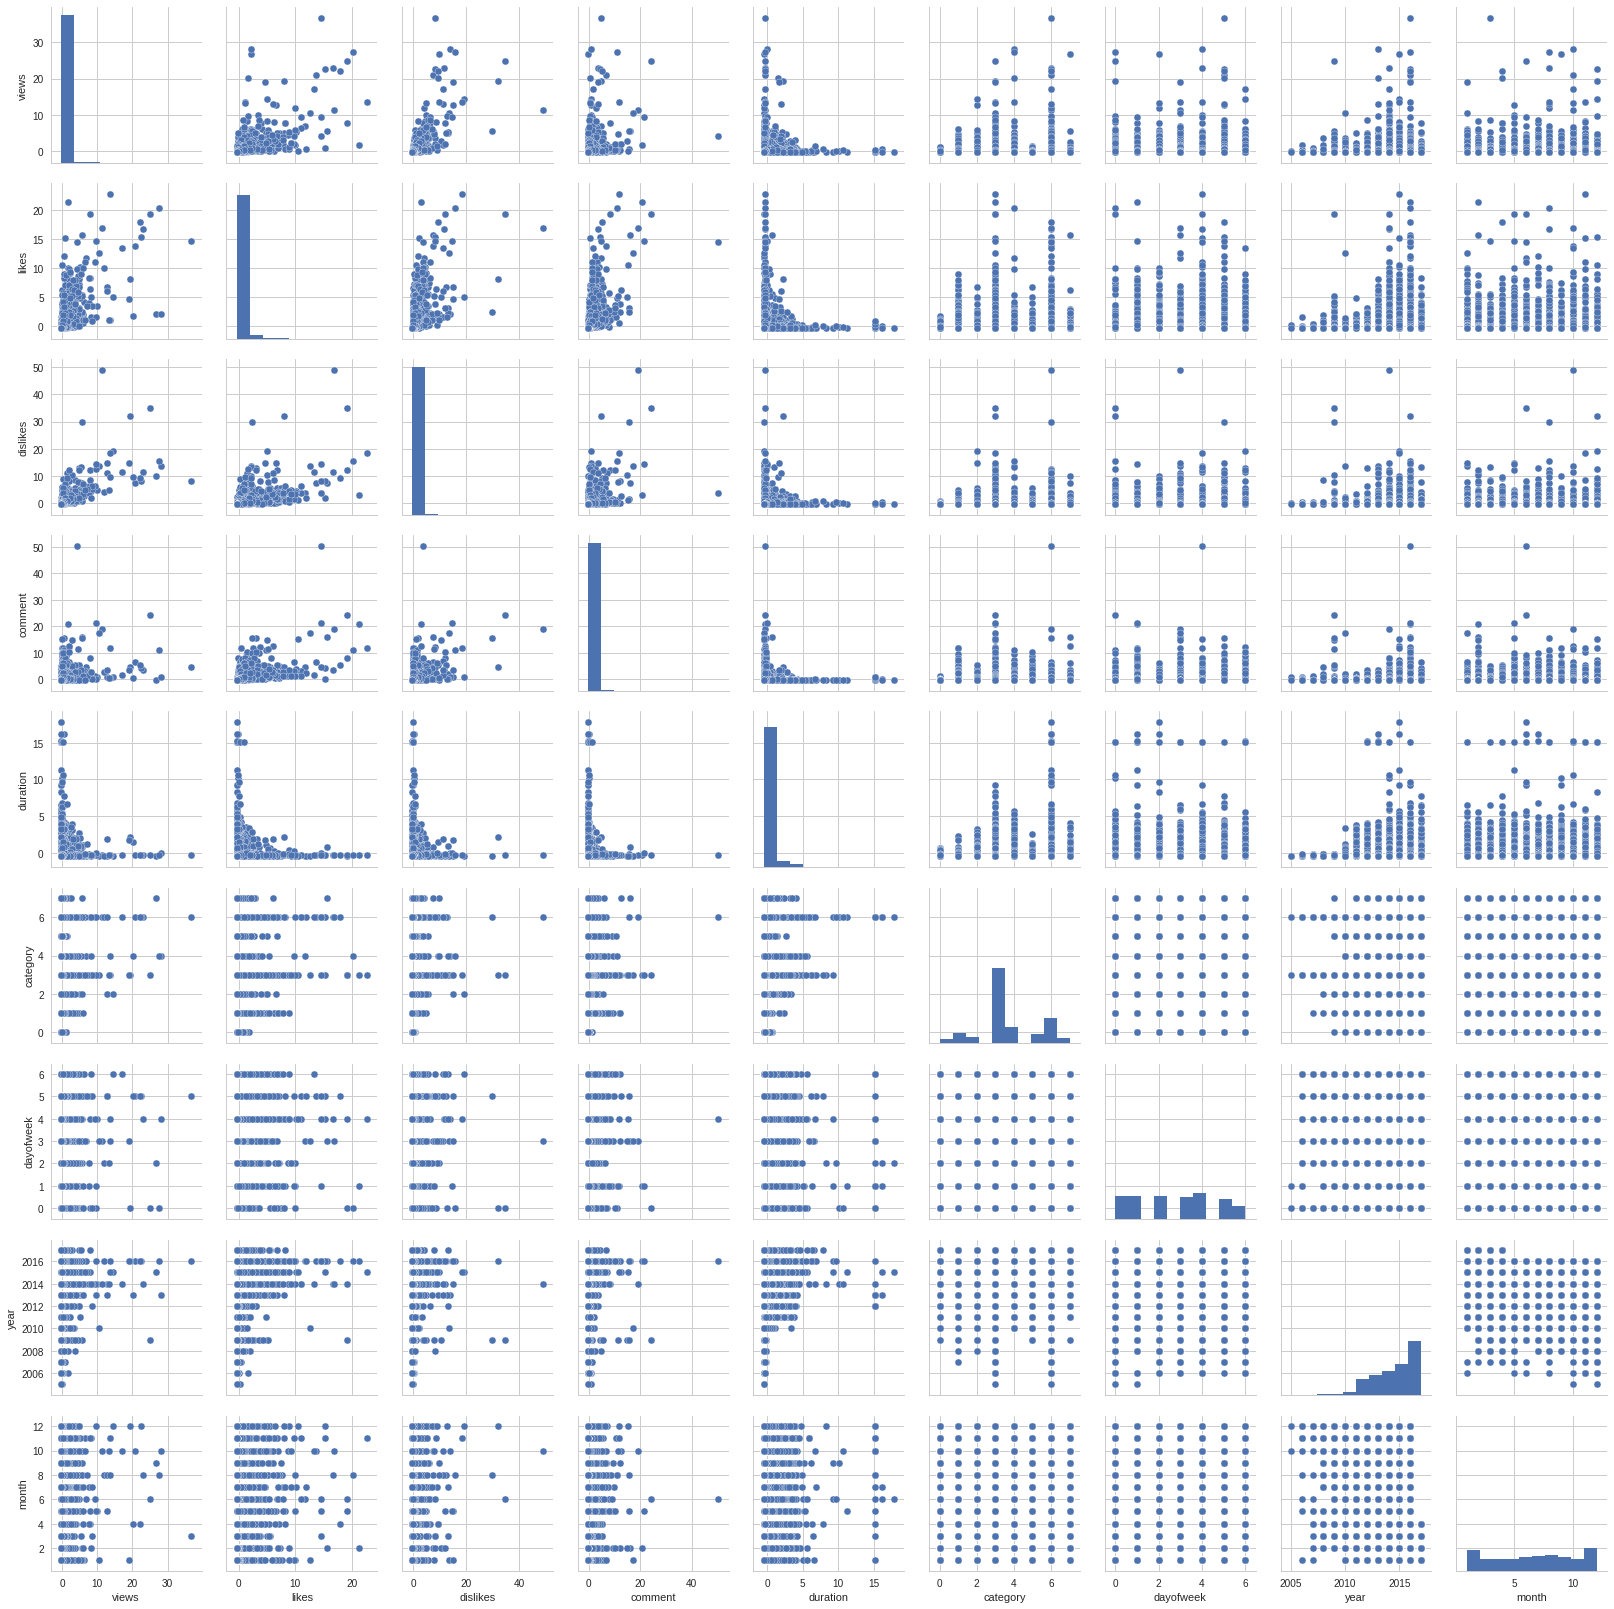

In [578]:
sns.pairplot(x_train)

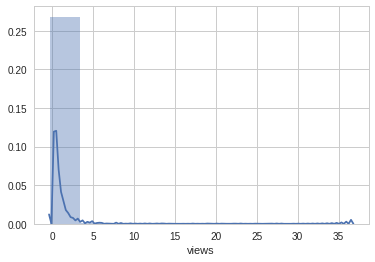

In [590]:
sns.distplot(x_train.views, bins = 10)

In [587]:
x_train.head()

,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,0.142176,0.707556,0.110809,0.465447,-0.251770,5,2,2016,9
1,-0.291273,-0.327420,-0.247895,-0.269562,-0.202999,3,5,2016,10
2,-0.291140,-0.331209,-0.249883,-0.272262,-0.390314,2,5,2016,7
3,-0.030692,-0.239288,-0.089907,-0.170346,-0.335932,7,2,2016,7
4,-0.291711,-0.334143,-0.249883,-0.273612,-0.435632,3,2,2016,6


In [641]:
columns = ['views', 'likes', 'dislikes', 'comment']

In [642]:
for x in columns:
    temp = x_train[x]
    mean = temp.mean()
    std = temp.std()
    final_list = [z for z in temp if (z > mean - 3 * std)]
    final_list = [z for z in final_list if (z < mean + 3*std)]
    temp = Series(final_list)
    x_train[x] = temp

In [643]:
x_train.head()

,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,0.142176,0.707556,0.110809,0.465447,-0.251770,5,2,2016,9
1,-0.291273,-0.327420,-0.247895,-0.269562,-0.202999,3,5,2016,10
2,-0.291140,-0.331209,-0.249883,-0.272262,-0.390314,2,5,2016,7
3,-0.030692,-0.239288,-0.089907,-0.170346,-0.335932,7,2,2016,7
4,-0.291711,-0.334143,-0.249883,-0.273612,-0.435632,3,2,2016,6


In [644]:
x_train.shape

(14634, 9)

In [645]:
x_train.dropna(inplace=True)

In [646]:
x_train.shape

(14065, 9)

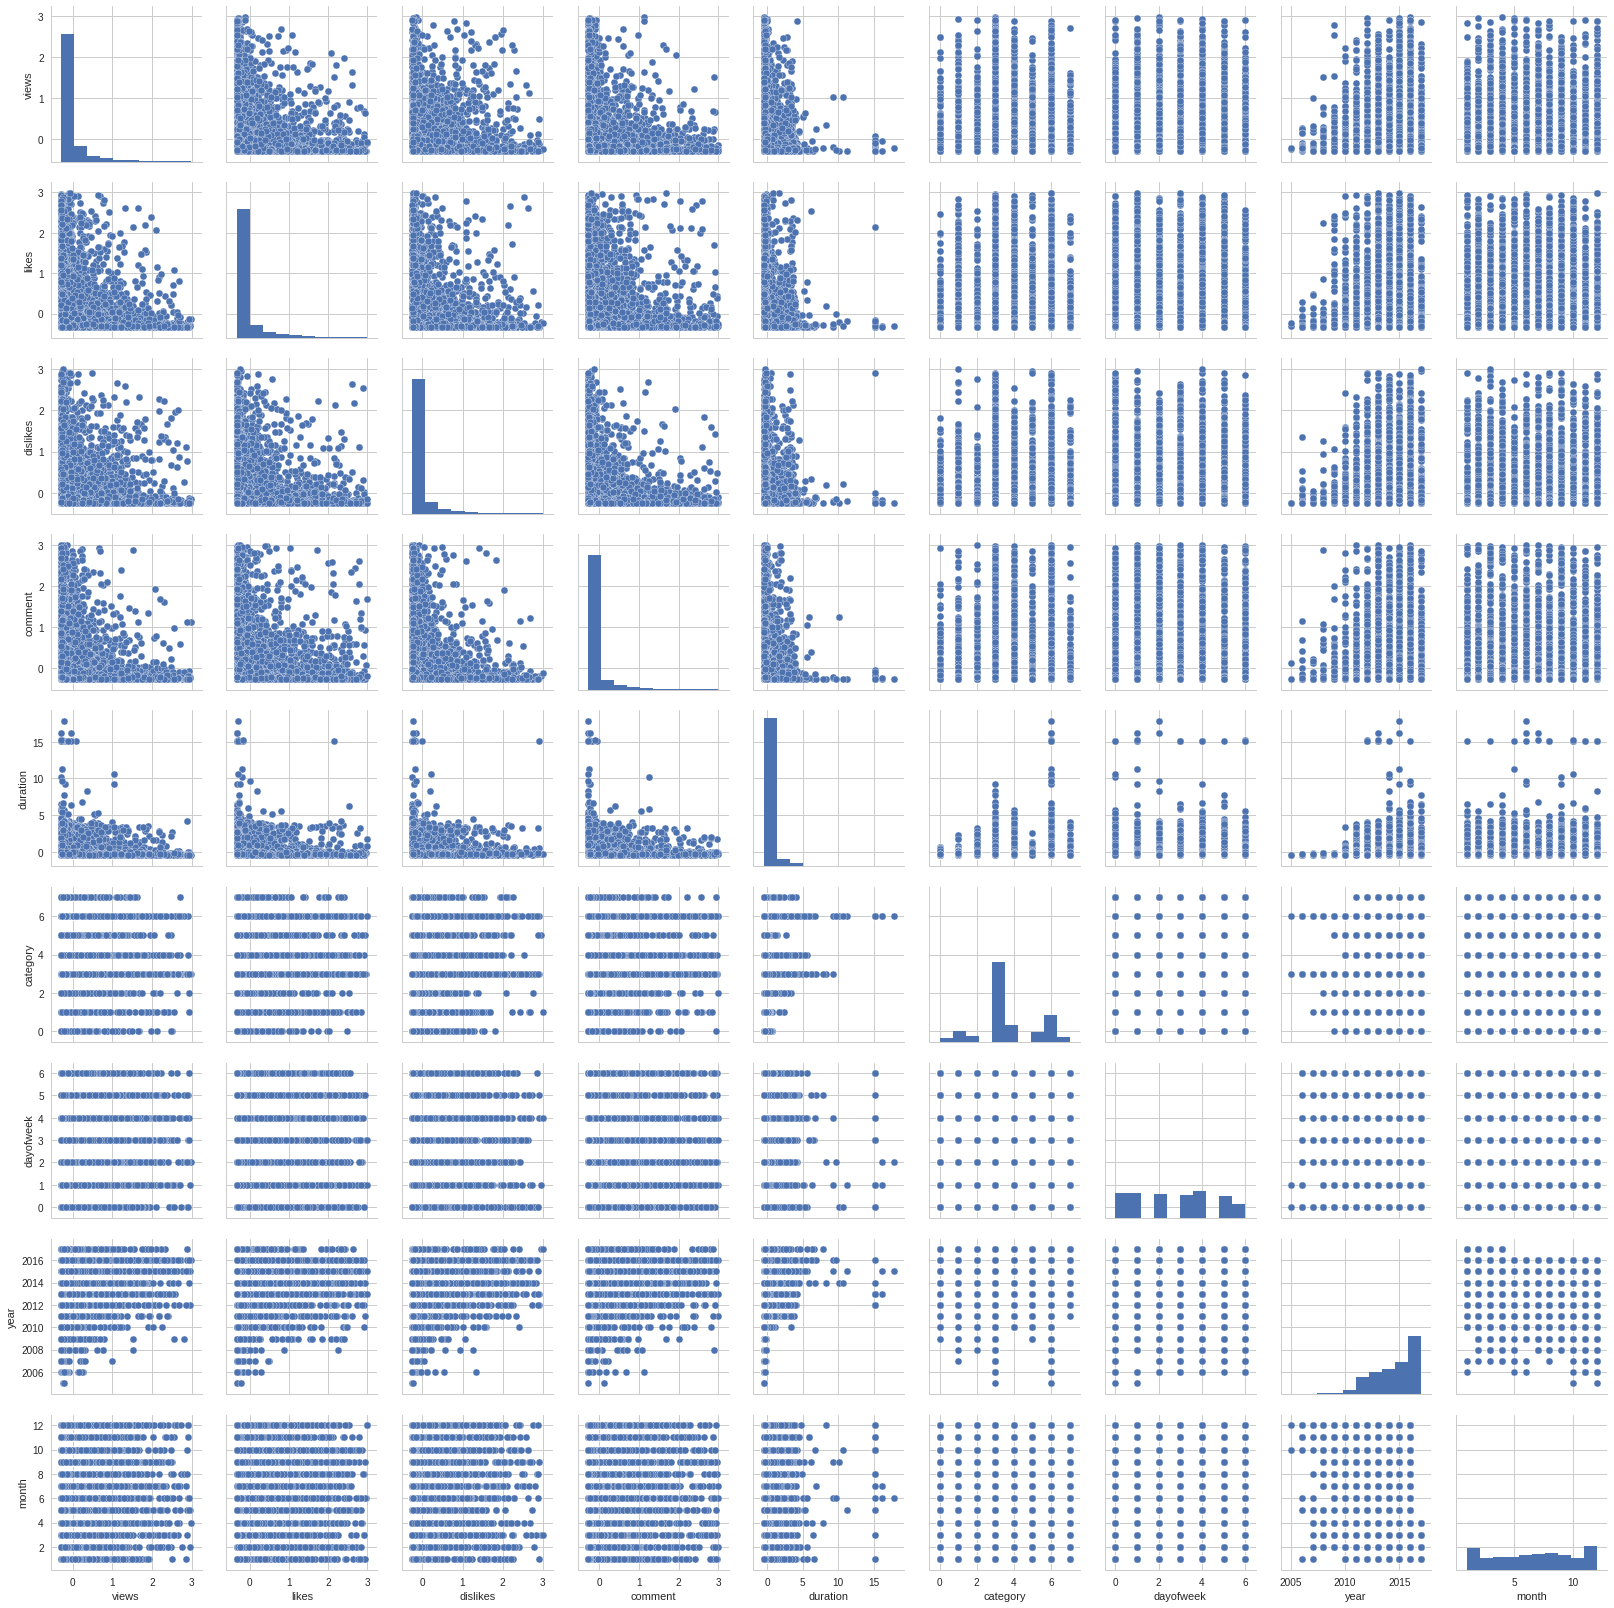

In [647]:
sns.pairplot(x_train)

In [588]:
views = x_train.views

In [598]:
mean = views.mean()
std = views.std()

In [597]:
views.mean()

-4.11193712824132e-17

In [599]:
final_list = [x for x in views if (x > mean - 2 * std)]
final_list = [x for x in final_list if (x < mean + 2*std)]

In [601]:
views = Series(final_list)

In [604]:
x_train.views = views

In [605]:
x_train.head()

,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,0.142176,0.707556,0.110809,0.465447,-0.251770,5,2,2016,9
1,-0.291273,-0.327420,-0.247895,-0.269562,-0.202999,3,5,2016,10
2,-0.291140,-0.331209,-0.249883,-0.272262,-0.390314,2,5,2016,7
3,-0.030692,-0.239288,-0.089907,-0.170346,-0.335932,7,2,2016,7
4,-0.291711,-0.334143,-0.249883,-0.273612,-0.435632,3,2,2016,6


In [607]:
x_train.shape

(14634, 9)

In [608]:
x_train.dropna(inplace=True)

In [609]:
x_train.shape

(14030, 9)

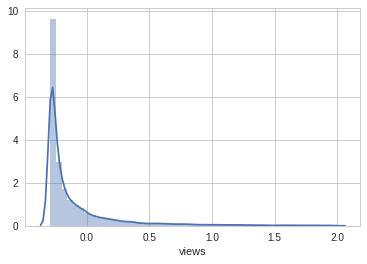

In [610]:
sns.distplot(x_train.views)